In [1]:
config = {
    "path": {
        "dataset_path":"C:\\Users\\Cheon\\Dev\\deepcheese\\lob_data",
        "model_path":"C:\\Users\\Cheon\\Dev\\deepcheese\\models"
    },

    "dataset": {
        "ticker": "KQ150",
        "open": "090000",
        "close": "154500",
        "orderbook_level": 5,
        "time_window": 100,
        "price_window" : 10,
        "max_amount": 5,
        "train_ratio": 0.5,
        "val_ratio": 0.2,
        "test_ratio": 0.3,
        "predict_horizon": 100,
        "threshold": 0.0003
        #"threshold": 0.0002
    }
}

In [2]:
import os
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt


_config_path = config["path"]
_config_dataset = config["dataset"]


def time_to_idx(timestring):
    hour = int(timestring[:2])
    minute = int(timestring[2:4])
    second = int(timestring[4:])
    return (hour - 9) * 60 * 60 + minute * 60 + second


def idx_to_time(idx):
    second = idx % 60
    minute = int((idx - second) / 60) % 60
    hour = (idx - second - minute * 60) // (60 * 60)
    return '%02d:%02d:%02d' % (hour + 9, minute, second)


def get_file_path(data_type, ticker, date="*"):
    match data_type:
        case "tradeprint":
            filename1 = "H0IFCNT0"
        case "orderbook":
            filename1 = "H0IFASP0"

    match ticker:
        case "KS200":
            filename2 = "101T*"
        case "KQ150":
            filename2 = "106T*"

    if date == "*":
        return os.path.join(_config_path["dataset_path"], f"{filename1}_{filename2}_{date}.csv")
    else:
        return glob.glob(os.path.join(_config_path["dataset_path"], f"{filename1}_{filename2}_{date}.csv"))[0]


def get_file_list(data_type, ticker):
    return glob.glob(get_file_path(data_type, ticker))


def get_days_list(ticker):
    def extract_days(file_list):
        day_list = []
        for filename in file_list:
            day_list.append(filename.split('.')[0].split('_')[-1])
        return day_list

    # return days which has coupled tradeprint and orderbook data
    day_list_1 = extract_days(get_file_list("tradeprint", ticker))
    day_list_2 = extract_days(get_file_list("orderbook", ticker))
    intersect_day = list(set(day_list_1) & set(day_list_2))
    intersect_day.sort()
    return intersect_day


def load_orderbook_data(filename):
    mul_fac = 10
    orderbook_level = 5

    time_data = []
    orderbook_data = []

    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for idx, row in enumerate(reader):
            temp_timestamp = row[1]
            update = len(time_data) == 0 or temp_timestamp != time_data[-1]
            if (not row[2] == '0.00') and update:
                # Process orderbook data in single timestamp
                temp_orderbook_data = []
                for i in range(1, orderbook_level + 1):
                    single_level = [
                        ###################################################
                        int(float(row[1+i])*mul_fac), # price  | ask side
                        int(row[21+i]),               # volume |
                        ###################################################
                        int(float(row[6+i])*mul_fac), # price  | bid side
                        int(row[26+i])                # volume |
                        ###################################################
                    ]
                    temp_orderbook_data.append(single_level)
                time_data.append(temp_timestamp)
                orderbook_data.append(temp_orderbook_data)
    # sparse sampling
    time_data = np.array(time_data)[::1]
    orderbook_data = np.array(orderbook_data)[::1]
    return time_data, orderbook_data


In [3]:
import torch
import numpy as np


class MovingWindow:
    def __init__(self, day):
        self.day = day
        self.ticker = _config_dataset["ticker"]
        self.level = _config_dataset["orderbook_level"]
        self.T = _config_dataset["time_window"]
        self.W = _config_dataset["price_window"]
        self.max_quantity = _config_dataset["max_amount"]
        self.predict_horizon = _config_dataset["predict_horizon"]
        self.threshold = _config_dataset["threshold"]


        file_path = get_file_path("orderbook", self.ticker, day)
        self.orderbook_time, self.orderbook_data = load_orderbook_data(file_path)
        self.movingwindow = []
        self.ticks = []

        self.start_idx = max(self.T - 1, self.predict_horizon)
        self.end_idx = len(self.orderbook_data) - self.predict_horizon - 1

        self.midprice = []
        self.ask1 = []
        self.bid1 = []
        self.midprice_idx = []
        self.__fill_movingwindow__(self.orderbook_data)

        self.label = []
        self.__fill_label__()

    def __len__(self):
        return self.end_idx - self.start_idx + 1
    
    def __moving_window_shot__(self, lob, ticks, data_min, data_max):
        lob_shot = lob.copy()
        lob_shot[:, 1:4:2] = np.minimum(lob_shot[:, 1:4:2], self.max_quantity)
        lob_shot[:,3] = -lob_shot[:,3]

        for i in range(1, lob_shot.shape[0]):
            lob_shot[i, 1:4:2] = lob_shot[i-1, 1:4:2] + lob_shot[i, 1:4:2]

        ask_side = lob_shot[:, 0:2]
        bid_side = lob_shot[::-1, 2:4]

        midprice = (ask_side[0, 0] + bid_side[0, 0]) / 2
        ask1 = ask_side[0, 0]
        bid1 = bid_side[0, 0]
        midprice_idx = round(midprice - (data_min - self.W))

        moving_window_shot = np.zeros(ticks.shape)

        # bid side
        for i in range(5):
            if i == 0:
                start_idx = 0
            else:
                start_idx = bid_side[i-1, 0] - (data_min - self.W) + 1
            end_idx = bid_side[i, 0] - (data_min - self.W)
            moving_window_shot[start_idx:end_idx+1] = bid_side[i, 1]

        # ask side
        for i in range(5):
            if i == 4:
                end_idx = len(moving_window_shot)
            else:
                end_idx = ask_side[i + 1, 0] - (data_min - self.W) + 1
            start_idx = ask_side[i, 0] - (data_min - self.W)
            moving_window_shot[start_idx:end_idx+1] = ask_side[i, 1]

        return moving_window_shot, midprice, ask1, bid1, midprice_idx


    def __fill_movingwindow__(self, data):
        processed_data = []
        midprice = []
        ask1 = []
        bid1 = []
        midprice_idx = []

        data_min = np.min(data[:,:,0:3:2].flatten())
        data_max = np.max(data[:,:,0:3:2].flatten())
        ticks = np.arange(data_min - self.W, data_max + self.W + 1, 1)

        for i in range(data.shape[0]):
            lob_shot, midprice_, ask_1, bid_1, midprice_idx_ = self.__moving_window_shot__(data[i], ticks, data_min, data_max)
            processed_data.append(lob_shot)
            midprice.append(midprice_)
            ask1.append(ask_1)
            bid1.append(bid_1)
            midprice_idx.append(midprice_idx_)

        self.movingwindow = np.array(processed_data) / (self.max_quantity * 5)
        self.ticks = ticks
        self.midprice = np.array(midprice)
        self.ask1 = np.array(ask1)
        self.bid1 = np.array(bid1)
        self.midprice_idx = np.array(midprice_idx)
        

    def __fill_label__(self):
        label = np.zeros(self.end_idx - self.start_idx + 1)

        for index in range(self.end_idx - self.start_idx + 1):
            index_re = index + self.start_idx
            m_prev = np.mean(self.midprice[index_re - self.predict_horizon:index_re])
            m_next = np.mean(self.midprice[index_re + 1:index_re + self.predict_horizon + 1])
            l = (m_next - m_prev) / m_prev

            if l > self.threshold:
                tmp_label = 2
            elif l < -self.threshold:
                tmp_label = 0
            else:
                tmp_label = 1
            label[index] = tmp_label
        self.label = label
        # self.movingwindow = self.movingwindow[self.start_idx: self.end_idx + 1]
        # self.midprice_idx = self.midprice_idx[self.start_idx: self.end_idx + 1]
        # self.midprice = self.midprice[self.start_idx: self.end_idx + 1]
        # self.ask1 = self.ask1[self.start_idx: self.end_idx + 1]
        # self.bid1 = self.bid1[self.start_idx: self.end_idx + 1]

    def __getitem__(self, index):
        index_re = index + self.start_idx
        shot = self.movingwindow[index_re-self.T+1:index_re+1,
                                 self.midprice_idx[index_re]-self.W:self.midprice_idx[index_re]+self.W].T
        return np.expand_dims(shot, axis=0), self.label[index]
    
    def get_price(self):
        return self.midprice[self.start_idx:self.end_idx + 1], \
               self.ask1[self.start_idx:self.end_idx + 1], \
               self.bid1[self.start_idx:self.end_idx + 1]


In [4]:
#from multiprocessing import Pool
from ray.util.multiprocessing import Pool

class Dataset:
    def __init__(self, days):
        self.days = days
        self.day_datasets = []

        with Pool() as pool:
            self.day_datasets = pool.map(MovingWindow, self.days)


def get_datasets(verbose=False):
    days = get_days_list(_config_dataset["ticker"])

    val_length = max(round(len(days) * _config_dataset["val_ratio"]), 1)
    test_length = max(round(len(days) * _config_dataset["test_ratio"]), 1)
    train_length = len(days) - (val_length + test_length)

    train_days = days[:train_length]#[:2]
    val_days = days[train_length:train_length + val_length]#[:1]
    test_days = days[train_length + val_length:]#[:1]

    if verbose:
        print(f"% {len(train_days)} days for train ({train_days[0]} ~ {train_days[-1]})")
        print(f"% {len(val_days)} days for validation ({val_days[0]} ~ {val_days[-1]})")
        print(f"% {len(test_days)} days for test ({test_days[0]} ~ {test_days[-1]})")

    train_dataset = Dataset(train_days)
    val_dataset = Dataset(val_days)
    test_dataset = Dataset(test_days)

    return train_dataset, val_dataset, test_dataset


In [5]:
train_dataset, val_dataset, test_dataset = get_datasets(verbose=True)

% 38 days for train (2023-04-03 ~ 2023-05-26)
% 15 days for validation (2023-05-30 ~ 2023-06-21)
% 23 days for test (2023-06-22 ~ 2023-07-24)


2024-03-08 22:20:40,212	INFO worker.py:1673 -- Started a local Ray instance.


In [6]:
test_loader = torch.utils.data.DataLoader(test_dataset.day_datasets[0], batch_size=64, shuffle=False)

In [7]:
test_dataset.day_datasets[0][2][0].shape

(1, 20, 100)

In [8]:
for data, label in test_loader:
    print(data.shape, label.shape)
    break

torch.Size([64, 1, 20, 100]) torch.Size([64])


C:\Users\Cheon\Dev\deepcheese\.venv\Lib\site-packages\torch\utils\data\_utils\collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


In [9]:
def get_loader(dataset, batch_size):
    loaders = []
    for day_dataset in dataset.day_datasets:
        loaders.append(torch.utils.data.DataLoader(day_dataset, batch_size=batch_size, shuffle=True))
    return loaders

train_loader = get_loader(train_dataset, 512)
val_loader = get_loader(val_dataset, 512)
test_loader = get_loader(test_dataset, 512)

In [10]:
def get_label(dataset):
        label = []
        for day_dataset in dataset.day_datasets:
            label.append(day_dataset.label)
        label = np.concatenate(label, 0)
        return label


for dataset in [train_dataset, val_dataset, test_dataset]:
    label = get_label(dataset)
    print("% label distribution")
    for i in [0, 1, 2]:
        print(len(np.where(label == i)[0]))

% label distribution
246208
343859
250294
% label distribution
86304
153492
87580
% label distribution
146713
214710
159929


In [11]:
for day_loader in train_loader:
    for data, label in day_loader:
        print(data.shape, label.shape)
        break
    break

torch.Size([512, 1, 20, 100]) torch.Size([512])


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(torch.nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.input_size = _config_dataset["price_window"] * 2
        self.num_layers = 1
        self.output_size = 3
        self.hidden_size = 64
        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, self.output_size)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.squeeze(1)
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_size = _config_dataset["time_window"] * _config_dataset["price_window"] * 2
        self.fc0 = torch.nn.Linear(self.input_size, 100)
        self.fc1 = torch.nn.Linear(100, 50)
        self.fc2 = torch.nn.Linear(50, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.reshape(-1, self.input_size)
        out = self.fc0(x)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.fc1 = torch.nn.Linear(3072, 3)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = x.permute(0, 1, 3, 2)
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

In [13]:
model = MLP().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


C:\Users\Cheon\Dev\deepcheese\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
model(torch.rand((64, 1, _config_dataset["price_window"] * 2, _config_dataset["time_window"])).to(device)).shape

torch.Size([64, 3])

In [15]:
import torch
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = []
    running_acc = []
    for day_loader in train_loader:
        for input, target in day_loader:
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.int64)

            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            acc = (torch.count_nonzero(torch.argmax(output, dim=1) == target).item()
                   / target.size(0))

            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
            running_acc.append(acc)
    epoch_loss = np.mean(running_loss)
    epoch_acc = np.mean(running_acc)
    return epoch_loss, epoch_acc


def validation(model, test_loader, criterion, scheduler):
    model.eval()
    running_loss = []
    running_acc = []
    for day_loader in test_loader:
        for input, target in day_loader:
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.int64)

            output = model(input)
            loss = criterion(output, target)
            acc = (torch.count_nonzero(torch.argmax(output, dim=1) == target).item()
                   / target.size(0))

            running_loss.append(loss.item())
            running_acc.append(acc)
    epoch_loss = np.mean(running_loss)
    epoch_acc = np.mean(running_acc)
    scheduler.step(epoch_loss)
    return epoch_loss, epoch_acc

In [16]:
epochs = 5

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    val_epoch_loss, val_epoch_acc = validation(model, val_loader, criterion, scheduler)

    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")

Epoch 1/5
Train Loss: 0.8304 | Train Acc: 0.6203
Val Loss: 0.7914 | Val Acc: 0.6477
Epoch 2/5
Train Loss: 0.8109 | Train Acc: 0.6258
Val Loss: 0.7919 | Val Acc: 0.6471
Epoch 3/5
Train Loss: 0.8096 | Train Acc: 0.6264
Val Loss: 0.7904 | Val Acc: 0.6481
Epoch 4/5
Train Loss: 0.8087 | Train Acc: 0.6268
Val Loss: 0.7906 | Val Acc: 0.6482
Epoch 5/5
Train Loss: 0.8078 | Train Acc: 0.6272
Val Loss: 0.7897 | Val Acc: 0.6481


In [143]:
example_day = train_dataset.day_datasets[0]

midprice, ask1, bid1 = example_day.get_price()

In [144]:
example_loader = torch.utils.data.DataLoader(example_day, batch_size=512, shuffle=False)

pred = []
conf = []
for input, target in example_loader:
    input = input.to(device, dtype=torch.float)
    target = target.to(device, dtype=torch.int64)

    output = model(input)
    temp_pred = torch.argmax(output, dim=1).cpu().detach().numpy()
    temp_conf = np.max(torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy(), axis=1)
    pred.append(temp_pred)
    conf.append(temp_conf)
pred = np.concatenate(pred, 0)
conf = np.concatenate(conf, 0)

Text(0, 0.5, 'Label')

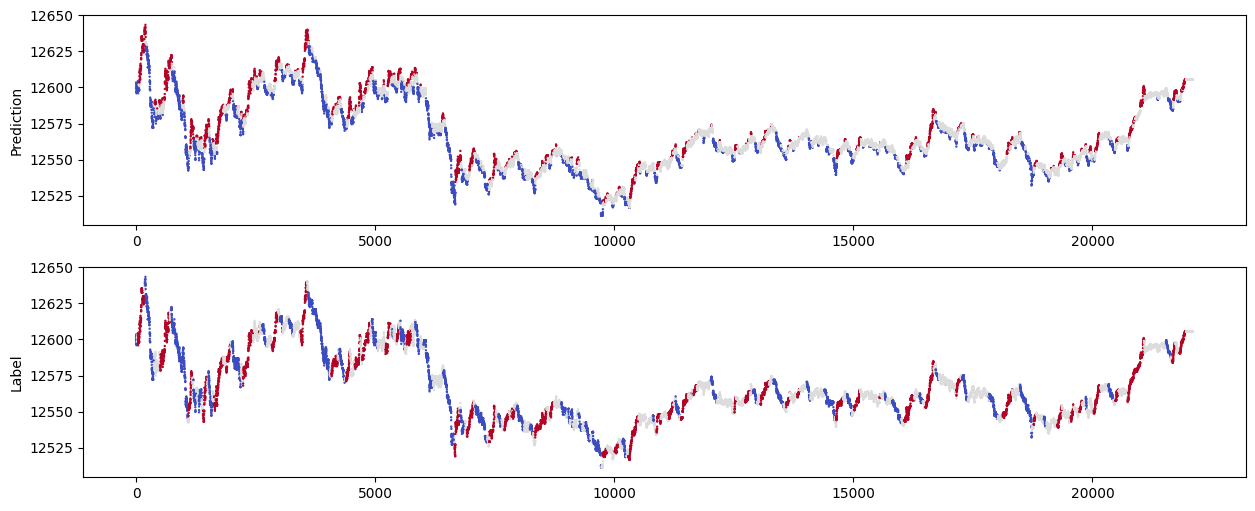

In [145]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.scatter(np.arange(len(midprice)), midprice, s=0.5, c=pred, cmap='coolwarm')
plt.ylabel("Prediction")
plt.subplot(2, 1, 2)
plt.scatter(np.arange(len(midprice)), midprice, s=0.5, c=example_day.label, cmap='coolwarm')
plt.ylabel("Label")

In [146]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(accuracy_score(example_day.label, pred))
print(classification_report(example_day.label, pred))
print(confusion_matrix(example_day.label, pred, normalize='true'))

0.6431867535287731
              precision    recall  f1-score   support

         0.0       0.63      0.64      0.63      5863
         1.0       0.62      0.72      0.67     10225
         2.0       0.72      0.52      0.60      6016

    accuracy                           0.64     22104
   macro avg       0.66      0.63      0.63     22104
weighted avg       0.65      0.64      0.64     22104

[[0.64096879 0.33122975 0.02780147]
 [0.17828851 0.71726161 0.10444988]
 [0.06615691 0.41439495 0.51944814]]


In [156]:
class RLDataset(torch.utils.data.Dataset):
    def __init__(self, day, dataset, label, midprice, ask1, bid1):
        self.day = day

        self.dataset = dataset
        self.label = label
        self.midprice = midprice
        self.ask1 = ask1
        self.bid1 = bid1

    def __len__(self):
        return len(self.midprice)

    def __getitem__(self, idx):
        return self.dataset[idx]
        
    def __getprice__(self):
        return self.midprice, self.ask1, self.bid1

In [157]:
def get_rl_dataset(dataset):
    midprice, ask1, bid1 = dataset.get_price()
    day = dataset.day

    example_loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    conf = []
    label = []
    for input, target in example_loader:
        input = input.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.int64)
        output = model(input)
        temp_conf = torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy()
        conf.append(temp_conf)
        label.append(target.cpu().detach().numpy())
    conf = np.concatenate(conf, axis=0)
    label = np.concatenate(label, axis=0)

    return RLDataset(day, conf, label, midprice, ask1, bid1)

In [158]:
temp_day = train_dataset.day_datasets[0]
rl_dataset = get_rl_dataset(temp_day)

In [159]:
def get_rl_loader(dataset):
    loaders = []
    for day_dataset in dataset.day_datasets:
        loaders.append(get_rl_dataset(day_dataset))
    return loaders

rl_train_loader = get_rl_loader(train_dataset)
rl_val_loader = get_rl_loader(val_dataset)
rl_test_loader = get_rl_loader(test_dataset)

In [152]:
from ray.util.multiprocessing import Pool
import gymnasium as gym
from gymnasium import spaces

class MarketEnv(gym.Env):
    def __init__(self, rl_loader) -> None:
        self.day_datasets = rl_loader
        self.days = [day_dataset.day for day_dataset in self.day_datasets]
        
        self.observation_space = spaces.Dict({
            "position": spaces.Box(low=-1, high=1, shape=(1, ), dtype=np.float64),
            "obs": spaces.Box(low=0, high=1, shape=(3, ), dtype=np.float64)
        })
        self.action_space = spaces.Discrete(3)

        self.reset()

    def reset(self, seed=None):
        self.day_idx = np.random.randint(len(self.days))
        self.day = self.days[self.day_idx]
        self.day_dataset = self.day_datasets[self.day_idx]
        self.day_len = len(self.day_dataset)
        self.max_position = 5
        self.fee = 0.003 / 100

        self.t = 0
        self.t_max = self.day_len - 1

        self.midprice, self.ask1, self.bid1 = self.day_dataset.__getprice__()
        self.cumulative_reward = np.zeros(self.day_len)
        self.position = np.zeros(self.day_len)
        self.cash = np.zeros(self.day_len)
        self.balance = np.zeros(self.day_len)
        
        self.trade_timing = 0
        self.trade_count = 0
        
        self.long_inventory = []
        self.short_inventory = []
        return {"position": np.array([self.position[self.t]/self.max_position]), "obs": self.day_dataset[self.t]}, {}

    def step(self, action):
        self.t += 1
        
        # action: 0 - hold, 1 - buy, 2 - sell
        if action == 1 and self.position[self.t - 1] < self.max_position:
            position_change = 1
        elif action == 2 and self.position[self.t - 1] > 0:#-self.max_position:
            position_change = -1
        else:
            position_change = 0
            
        # position_change = action - self.position[self.t - 1]
        
        # trading price
        if position_change == 1:
            trade_price = self.ask1[self.t]
        elif position_change == -1:
            trade_price = self.bid1[self.t]
        else:
            trade_price = self.midprice[self.t]
        
        self.position[self.t] = self.position[self.t - 1] + position_change
        self.cash[self.t] = self.cash[self.t - 1] - trade_price * position_change - abs(position_change) * self.fee * trade_price
        self.balance[self.t] = self.cash[self.t] + self.position[self.t] * self.midprice[self.t]
        
        # if position_change == 0:
        #     reward = 0
        # else:
        #     if position_change == 1 and self.position[self.t] == 0:
        #         reward = self.balance[self.t] - self.balance[self.trade_timing]
        #     elif position_change == -1 and self.position[self.t] == 0:
        #         reward = self.balance[self.t] - self.balance[self.trade_timing]
        #     else:
        #         reward = 0

        if position_change != 0:
            self.trade_timing = self.t
            self.trade_count += 1
            
        reward = (self.balance[self.t] - self.balance[self.t - 1])

        # if position_change ==0:
        #     reward -= 0.1
            
        self.cumulative_reward[self.t] = self.cumulative_reward[self.t - 1] + reward
        done = self.t == self.t_max

        if done:
            state = None
            print(f"Day: {self.day}, Cumulative Reward: {self.cumulative_reward[self.t]}, Balance: {self.balance[self.t]}, Trade Count: {self.trade_count}")
            info = {
                "position": self.position,
                "balance": self.balance,
                "cumulative_reward": self.cumulative_reward,
                "midprice": self.midprice
            }
        else:
            state = self.day_dataset[self.t]
            info = {
                "position": self.position[self.t],
                "balance": self.balance[self.t],
                "cumulative_reward": self.cumulative_reward[self.t],
                "midprice": self.midprice[self.t]
            }
        
        state_pos = np.array([self.position[self.t]/self.max_position])
        truncated = False
        return {"position": np.array([self.position[self.t]/self.max_position]), "obs": state}, reward, done, truncated, info
    
    def evaluate_balance(self):
        self.position_history[self.t] = self.position
        self.balance_history[self.t] = self.balance
        self.cumulative_reward_history[self.t] = self.cumulative_reward
        return self.balance_history[-1]
    
    def close(self):
        pass
        

In [153]:
from stable_baselines3.common.env_checker import check_env

train_env = MarketEnv(rl_train_loader)
val_env = MarketEnv(rl_val_loader)
test_env = MarketEnv(rl_test_loader)

check_env(train_env)

In [154]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

eval_callback = EvalCallback(val_env, best_model_save_path=_config_path["model_path"],
                                log_path=_config_path["model_path"], eval_freq=100000,
                                deterministic=True, render=True, n_eval_episodes=3)

rl_model = PPO("MultiInputPolicy", train_env, verbose=False)

In [155]:
rl_model.learn(total_timesteps=10000000, callback=eval_callback)

Day: 2023-04-27, Cumulative Reward: -17908.09037999928, Balance: -17908.09037999928, Trade Count: 5715
Day: 2023-05-11, Cumulative Reward: -3131.7690599999623, Balance: -3131.7690599999623, Trade Count: 403
Day: 2023-04-04, Cumulative Reward: 124.7587799999892, Balance: 124.7587799999892, Trade Count: 43
Day: 2023-04-13, Cumulative Reward: 461.68455999999424, Balance: 461.68455999999424, Trade Count: 7


C:\Users\Cheon\Dev\deepcheese\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
C:\Users\Cheon\Dev\deepcheese\.venv\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Day: 2023-06-21, Cumulative Reward: 0.0, Balance: 0.0, Trade Count: 0
Day: 2023-06-13, Cumulative Reward: 0.0, Balance: 0.0, Trade Count: 0
Day: 2023-06-20, Cumulative Reward: 0.0, Balance: 0.0, Trade Count: 0
Eval num_timesteps=100000, episode_reward=0.00 +/- 0.00
Episode length: 22304.67 +/- 138.14
New best mean reward!
Day: 2023-04-20, Cumulative Reward: -1470.6278100000054, Balance: -1470.6278100000054, Trade Count: 9
Day: 2023-04-17, Cumulative Reward: 265.44754999999714, Balance: 265.44754999999714, Trade Count: 5
Day: 2023-05-15, Cumulative Reward: 189.18097999999736, Balance: 189.18097999999736, Trade Count: 5
Day: 2023-05-18, Cumulative Reward: -269.26898999999685, Balance: -269.26898999999685, Trade Count: 6
Day: 2023-06-15, Cumulative Reward: 0.0, Balance: 0.0, Trade Count: 0
Day: 2023-06-19, Cumulative Reward: 0.0, Balance: 0.0, Trade Count: 0
Day: 2023-06-02, Cumulative Reward: 0.0, Balance: 0.0, Trade Count: 0
Eval num_timesteps=200000, episode_reward=0.00 +/- 0.00
Episod

KeyboardInterrupt: 

In [ ]:
# test episode
obs, info = test_env.reset()
balance_hist = []
bench_hist = []
position_hist = []

done = False
while not done:
    #test_env.render()

    action, _ = rl_model.predict(obs)
    obs, reward, done, trunc, info = test_env.step(action)

    balance_hist.append(info['balance'])
    bench_hist.append(info['midprice'])
    position_hist.append(info['position'])

test_env.close()